<a href="https://colab.research.google.com/github/2020-nlp-c/nlp-statisticsmodel/blob/master/yykim/LSA_Topic_Moedling(sklearn_included).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
doc_ls = ['바나나 사과 포도 포도 짜장면', '사과 포도', '포도 바나나', '짜장면 짬뽕 탕수육', '볶음밥 탕수육',
          '짜장면 짬뽕', '라면 스시', '스시 짜장면', '가츠동 스시 소바', '된장찌개 김치찌개 김치', 
          '김치 된장 짜장면', '비빔밥 김치']
    

### TDM 생성 (문서-단어 행렬)

In [2]:
import numpy as np
import pandas as pd

In [3]:
total_token = (" ".join(doc_ls)).split(" ")
total_unique_token = list(np.unique(total_token))

In [4]:
tokenized_doc_ls = [doc.split(" ") for doc in doc_ls]
tokenized_doc_ls

[['바나나', '사과', '포도', '포도', '짜장면'],
 ['사과', '포도'],
 ['포도', '바나나'],
 ['짜장면', '짬뽕', '탕수육'],
 ['볶음밥', '탕수육'],
 ['짜장면', '짬뽕'],
 ['라면', '스시'],
 ['스시', '짜장면'],
 ['가츠동', '스시', '소바'],
 ['된장찌개', '김치찌개', '김치'],
 ['김치', '된장', '짜장면'],
 ['비빔밥', '김치']]

In [5]:
token_count_in_doc = []
for doc in tokenized_doc_ls:
    tmp = []
    for token in total_unique_token:
        tmp.append(doc.count(token))
    token_count_in_doc.append(tmp)
tdm = pd.DataFrame(token_count_in_doc, index=['문서{}'.format(i) for i in range(len(doc_ls))], columns=total_unique_token)
tdm

,가츠동,김치,김치찌개,된장,된장찌개,라면,바나나,볶음밥,비빔밥,사과,소바,스시,짜장면,짬뽕,탕수육,포도
문서0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,2
문서1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
문서2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
문서3,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0
문서4,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
문서5,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
문서6,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
문서7,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0
문서8,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0
문서9,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0


## 특이값 분해(SVD)

In [6]:
from sklearn.decomposition import TruncatedSVD

In [12]:
A = np.array(token_count_in_doc)

In [13]:
svd = TruncatedSVD(n_components = A.shape[0], n_iter=10)

In [14]:
U = svd.fit_transform(A)
s = svd.explained_variance_ratio_
VT = svd.components_

In [15]:
U.shape

(12, 12)

In [16]:
s.shape

(12,)

In [17]:
VT.shape

(12, 16)

## 토픽모델링: n개의 토픽

In [27]:
def _model_topic(A, n_topics, n_words): #행렬A에서 n_topics개의 토픽 추출, 토픽당 n_words개의 단어를 추출
    svd = TruncatedSVD(n_components=A.shape[0], n_iter=10)
    U = svd.fit_transform(A)
    s = svd.explained_variance_ratio_
    VT = svd.components_
    
    for topic in range(n_topics) :
        sort = np.argsort(VT[topic,:])[::-1]
        top = sort[0:n_words]

        words_group = []
        for i in top :
            words_group.append((total_unique_token[i],  '%.3f' %VT.T[:,topic][i]))
        print("Topic{}: {}".format(topic+1, words_group))


In [28]:
_model_topic(A, 4, 3)

Topic1: [('포도', '0.697'), ('짜장면', '0.486'), ('사과', '0.348')]
Topic2: [('짜장면', '0.584'), ('짬뽕', '0.356'), ('김치', '0.337')]
Topic3: [('김치', '0.611'), ('된장찌개', '0.264'), ('김치찌개', '0.264')]
Topic4: [('스시', '0.552'), ('김치', '0.371'), ('소바', '0.277')]


## 단어/문서간 유사도 구하기

In [20]:
from matplotlib import pyplot
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
def cosine_similarity(x, y):
    return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

In [22]:
#단어간 유사도
similarity = np.zeros((VT.shape[1],VT.shape[1]))
for i, word in enumerate(VT.T):
    for j, another_word in enumerate(VT.T):
        similarity[i][j] = cosine_similarity(word, another_word)

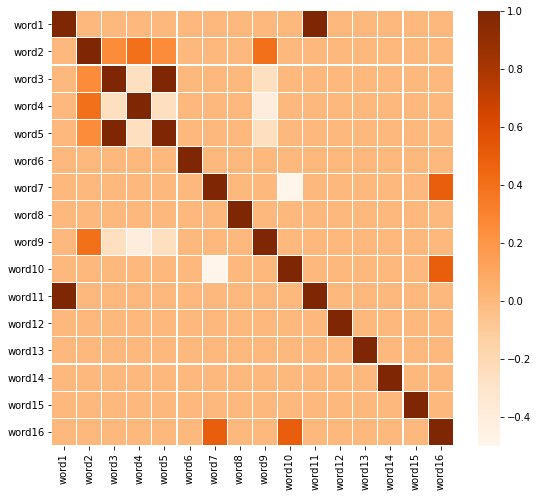

In [23]:
pyplot.figure(figsize=(9,8))
sns.heatmap(similarity,linewidth=.1, cmap='Oranges',xticklabels=["word{}".format(i+1) for i in range(similarity.shape[0])], yticklabels=["word{}".format(i+1) for i in range(similarity.shape[0])])

In [24]:
#문서간 유사도
similarity = np.zeros((U.shape[0],U.shape[0]))
for i, doc in enumerate(U):
    for j, another_doc in enumerate(U):
        similarity[i][j] = cosine_similarity(doc, another_doc)

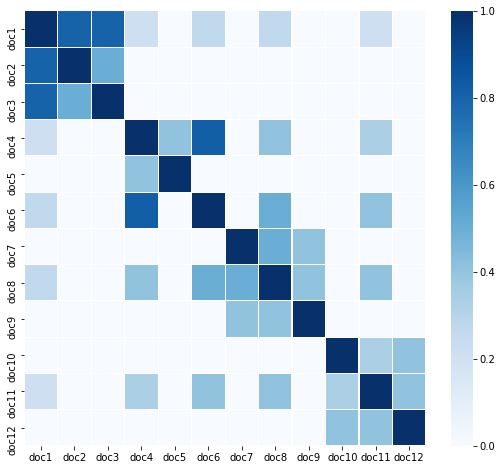

In [25]:
pyplot.figure(figsize=(9,8))
sns.heatmap(similarity,linewidth=.1, cmap='Blues',xticklabels=["doc{}".format(i+1) for i in range(similarity.shape[0])], yticklabels=["doc{}".format(i+1) for i in range(similarity.shape[0])])

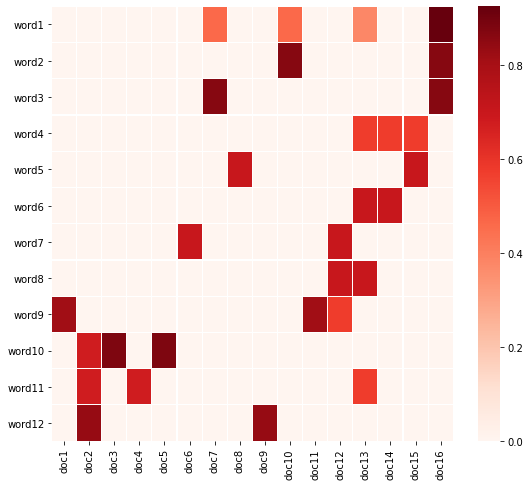

In [26]:
#문서-단어간 유사도
similarity = np.zeros((U.shape[0],VT.shape[1]))
for i, word in enumerate(U):
    for j, another_word in enumerate(VT.T):
        similarity[i][j] = cosine_similarity(word, another_word)
similarity.shape
pyplot.figure(figsize=(9,8))
sns.heatmap(similarity,linewidth=.1, cmap='Reds',xticklabels=["doc{}".format(i+1) for i in range(similarity.shape[1])], yticklabels=["word{}".format(i+1) for i in range(similarity.shape[0])])

## Class

In [69]:
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

class TopicModeling:
    def __init__(self, docs, package = 'manual'):
        self.docs = docs
        self.total_unique_token = []
        self.package = package
        self.U = np.zeros((1,1))
        self.s = np.zeros((1,1))
        self.VT = np.zeros((1,1))
        
    def _make_matrix(self):
        total_token = (" ".join(self.docs)).split(" ")
        self.total_unique_token = list(np.unique(total_token))
        tokenized_doc_ls = [doc.split(" ") for doc in doc_ls]
        
        token_count_in_doc = []
        for doc in tokenized_doc_ls:
            tmp = []
            for token in self.total_unique_token:
                tmp.append(doc.count(token))
            token_count_in_doc.append(tmp)        
        return np.array(token_count_in_doc)

    def _get_svm(self): 
        A = self._make_matrix()
        svd = TruncatedSVD(n_components= A.shape[0], n_iter=10)
        self.U = svd.fit_transform(A)
        self.s = svd.explained_variance_ratio_
        self.VT = svd.components_

    def predict(self, n_topics, n_words): #행렬A에서 n_topics개의 토픽 추출, 토픽당 n_words개의 단어를 추출
        if self.package == 'manual': 
            self._make_matrix()
            self._get_svm()
            for topic in range(n_topics) :
                sort = np.argsort(self.VT[topic,:])[::-1]
                top = sort[0:n_words]

                words_group = []
                for i in top :
                    words_group.append((self.total_unique_token[i], '%.3f' %self.VT.T[:,topic][i]))
                print("Topic{}: {}".format(topic+1, words_group))
        elif self.package == 'plain_sklearn':
            def my_tokenizer(text):
                return [w for w in text.split() if len(w) > 1]

            lsa_pipeline = Pipeline([('vect', CountVectorizer(tokenizer = my_tokenizer)),
                                    ('tfidf', TfidfTransformer(smooth_idf=True)),
                                    ('lsa', TruncatedSVD(n_components=n_topics, algorithm='randomized', n_iter=100)), ])
            lsa_pipeline.fit(self.docs)
            lsa = lsa_pipeline.named_steps['lsa']
            count_vect = lsa_pipeline.named_steps['vect']
            vocab = count_vect.get_feature_names() 
            for idx, topic in enumerate(lsa.components_):
                print("Topic %d:" % (idx), [(count_vect.get_feature_names()[i], topic[i].round(5)) for i in topic.argsort()[:-n_words - 1:-1]])

    #유사도 시각화
    def cosine_similarity(self, x, y):
        return np.dot(x, y)/(np.linalg.norm(x)*np.linalg.norm(y))

    def sim_btw_words(self):
        self._get_svm()
        similarity = np.zeros((self.VT.shape[1],self.VT.shape[1]))
        for i, word in enumerate(self.VT.T):
            for j, another_word in enumerate(self.VT.T):
                similarity[i][j] = self.cosine_similarity(word, another_word)
        sns.heatmap(similarity,linewidth=.1, cmap='Oranges',xticklabels=["word{}".format(i+1) for i in range(similarity.shape[0])], yticklabels=["word{}".format(i+1) for i in range(similarity.shape[0])])
        
    def sim_btw_docs(self):
        self._get_svm()
        similarity = np.zeros((self.U.shape[0],self.U.shape[0]))
        for i, doc in enumerate(self.U):
            for j, another_doc in enumerate(self.U):
                similarity[i][j] = cosine_similarity(doc, another_doc)
        sns.heatmap(similarity,linewidth=.1, cmap='Blues',xticklabels=["doc{}".format(i+1) for i in range(similarity.shape[0])], yticklabels=["doc{}".format(i+1) for i in range(similarity.shape[0])])

    def sim_btw_words_docs(self):
        self._get_svm()
        similarity = np.zeros((self.U.shape[0],self.VT.shape[1]))
        for i, word in enumerate(self.U):
            for j, another_word in enumerate(self.VT.T):
                similarity[i][j] = cosine_similarity(word, another_word)
        sns.heatmap(similarity,linewidth=.1, cmap='Reds',xticklabels=["doc{}".format(i+1) for i in range(similarity.shape[1])], yticklabels=["word{}".format(i+1) for i in range(similarity.shape[0])])

In [70]:
topicmodel = TopicModeling(docs=doc_ls)

In [71]:
topicmodel.predict(4,3)

Topic1: [('포도', '0.697'), ('짜장면', '0.486'), ('바나나', '0.348')]
Topic2: [('짜장면', '0.584'), ('짬뽕', '0.356'), ('김치', '0.337')]
Topic3: [('김치', '0.611'), ('된장찌개', '0.264'), ('김치찌개', '0.264')]
Topic4: [('스시', '0.552'), ('김치', '0.371'), ('가츠동', '0.277')]


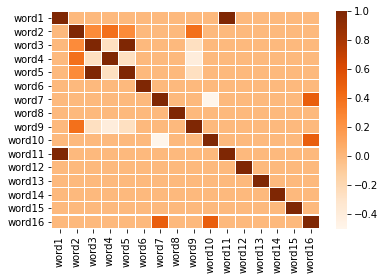

In [72]:
topicmodel.sim_btw_words()

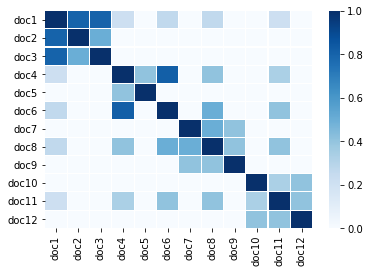

In [73]:
topicmodel.sim_btw_docs()

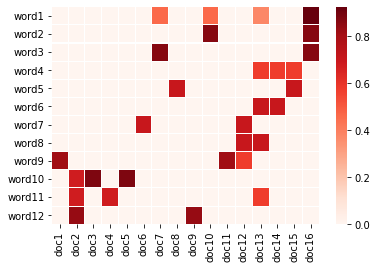

In [74]:
topicmodel.sim_btw_words_docs()

In [75]:
sklearn_topicmodel = TopicModeling(docs=doc_ls, package='plain_sklearn')

In [76]:
sklearn_topicmodel.predict(4,3)

Topic 0: [('포도', 0.58251), ('짜장면', 0.49916), ('바나나', 0.32971)]
Topic 1: [('짜장면', 0.43992), ('짬뽕', 0.39143), ('스시', 0.31495)]
Topic 2: [('스시', 0.70278), ('라면', 0.3528), ('소바', 0.25327)]
Topic 3: [('김치', 0.68201), ('비빔밥', 0.37258), ('된장찌개', 0.27163)]
